In [1]:
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.PDB import PDBParser
from collections import Counter
from itertools import product
import os
import pandas as pd
import numpy as np
from Bio.PDB import PDBParser
import matplotlib.pyplot as plt

In [18]:
def read_dca_scores(dca_path, L):
    count = 0
    dca_scores = []  
    with open(dca_path) as f:
        for line in f:
            if line.startswith("#"):
                continue  
            i, j, score = map(float, line.split())
            i, j = int(i) - 1, int(j) - 1  
            if abs(i-j) > 4:
                dca_scores.append((i, j, score))
                count+=1
            if count == L:
                break
    
    dca_scores.sort(key=lambda x: x[2], reverse=True)
    
    return dca_scores

In [3]:
def compare_freqs(i,j, stabilize, reference):

    pairs_stab = [(seq[i], seq[j]) for seq in stabilize if seq[i] not in '-.' and seq[j] not in '-.']
    freqs_stab = {key: value / len(pairs_stab) for key, value in Counter(pairs_stab).items()}

    pairs_ref = [(seq[i], seq[j]) for seq in reference if seq[i] not in '-.' and seq[j] not in '-.']
    freqs_ref = {key: value / len(pairs_ref) for key, value in Counter(pairs_ref).items()}
    
    AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
    max_diff = -100
    max_diff_pair = None
    for aa1, aa2 in product(AMINO_ACIDS, repeat=2):
        freq_stab_pair = freqs_stab.get((aa1, aa2), 0)
        freq_ref_pair = freqs_ref.get((aa1, aa2), 0)
        diff = freq_stab_pair - freq_ref_pair
        if diff > max_diff:
            max_diff = diff
            max_diff_pair = (aa1, aa2)
    
    return max_diff_pair, max_diff

In [4]:
def compare(dca_merg, dca_full, msa_cluster, msa_full):
    query = msa_full[0].seq
    results = []
    for i,j, score, clu_id in dca_merg:
        if (i,j) not in {(k, l) for k, l, _ in dca_full}:
            max_diff_pair, max_diff = compare_freqs(i,j, msa_cluster, msa_full) 
            q_i = query[i]
            q_j = query[j]
            if q_i != max_diff_pair[0] and q_j != max_diff_pair[1]:
                results.append([i+1,j+1,(q_i,q_j), clu_id, score,  max_diff_pair, max_diff])
    df = pd.DataFrame(results, columns=['i','j','query','cluster id','dca score', 'pair','diff'])
    return df

In [5]:
def find_contacts_single_chain(pdb_file, threshold=12.0):

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    chain = structure[0].get_list()[0]

    ca_atoms = [(residue["CA"], residue.get_id()[1]) for residue in chain if "CA" in residue]

    contacts = []
    for i in range(len(ca_atoms)):
        for j in range(i + 1, len(ca_atoms)):  
            atom_A, index_A = ca_atoms[i]
            atom_B, index_B = ca_atoms[j]

            distance = np.linalg.norm(atom_A.coord - atom_B.coord)
            if distance < threshold:
                contacts.append((index_A-1, index_B-1))

    return contacts

In [28]:
def plot_results(pdb_native, dca_full, pdb_alternative, df_sorted, ax, prot, p):

    i_nat, j_nat = zip(*pdb_native)
    di_nat, dj_nat = zip(*[(i, j) for i, j, _ in dca_full])

    i_alt, j_alt = zip(*pdb_alternative)
    di_alt, dj_alt = zip(*zip(df_sorted['i'], df_sorted['j']))
    
    if p == 1:
        labels = ['PDB','','DCA alternative','DCA full MSA']
    else:
        labels = ['','','','']
    
    ax.scatter(j_nat, i_nat, color='silver', label=labels[0], s=30)
    ax.scatter(i_alt, j_alt, color='silver', label=labels[1], s=30)
    
    ax.scatter(dj_nat, di_nat, color='red', label=labels[3], s=40, alpha=0.6)
    ax.scatter(di_alt, dj_alt, color='orange', label=labels[2], s=40, alpha=0.6)

    x_tick_frequency = int(max(i_alt)/3)  
    y_tick_frequency = int(max(i_alt)/3)
    ax.xaxis.set_major_locator(plt.MultipleLocator(x_tick_frequency))
    ax.yaxis.set_major_locator(plt.MultipleLocator(y_tick_frequency))
    ax.tick_params(axis='x', labelsize=14) 
    ax.tick_params(axis='y', labelsize=14)
    
    min_val = 0  
    max_val = max(max(j_nat), max(i_nat), max(dj_nat), max(di_nat), max(i_alt), max(j_alt))  
    ax.plot([min_val, max_val], [min_val, max_val], '--', color='black')

    ax.text(0, 0, "Full MSA", horizontalalignment='left', verticalalignment='top', fontsize=18)
    ax.text(0.5, 0, "Alternative", horizontalalignment='right', verticalalignment='bottom', rotation=90, fontsize=18)
    ax.set_title(prot, fontsize=18)


In [29]:
def main(prot):
    

    msa_full = AlignIO.read('../output_files/'+prot+'/sequence_files/full_MSA.fasta', "fasta")
    L = len(msa_full[0].seq)
    pdb_native = find_contacts_single_chain('../output_files/'+prot+'/results/fullMSA_noH.pdb', threshold=12.0)

    files = os.listdir('output_files/'+prot)
    full_dca_path = 'output_files/'+ prot + '/' +[f for f in files if "full" in f][0]
    dca_full = read_dca_scores(full_dca_path, L)
    
    clusters_dca_path = [f for f in files if "full" not in f]
    df = []
    for i,c in enumerate(clusters_dca_path):
        dca_clusters = read_dca_scores('output_files/'+prot+'/'+c, L)
        name = c.replace('PLMDCA_apc_fn_scores_','').replace('.txt','')
        dca_merg = [t + (name,) for t in dca_clusters]
        msa_cluster = AlignIO.read('../output_files/'+prot+'/clusters/'+name+'.fasta', 'fasta')
        df.append(compare(dca_merg[:L], dca_full[:L], msa_cluster, msa_full))
        if i == 0:
            pdb_file = '../output_files/'+ prot + '/results/' + name.replace('ter_','') + '.pdb'
            pdb_alternative = find_contacts_single_chain(pdb_file, threshold=12.0)
        
    final_df = pd.concat(df, ignore_index=True)
    df_sorted = final_df.sort_values(by='diff', ascending=False)
    df_sorted[:L].to_csv('output_files/'+prot+'_muts.csv')

    return df_sorted, dca_full[:L], pdb_native, pdb_alternative, L

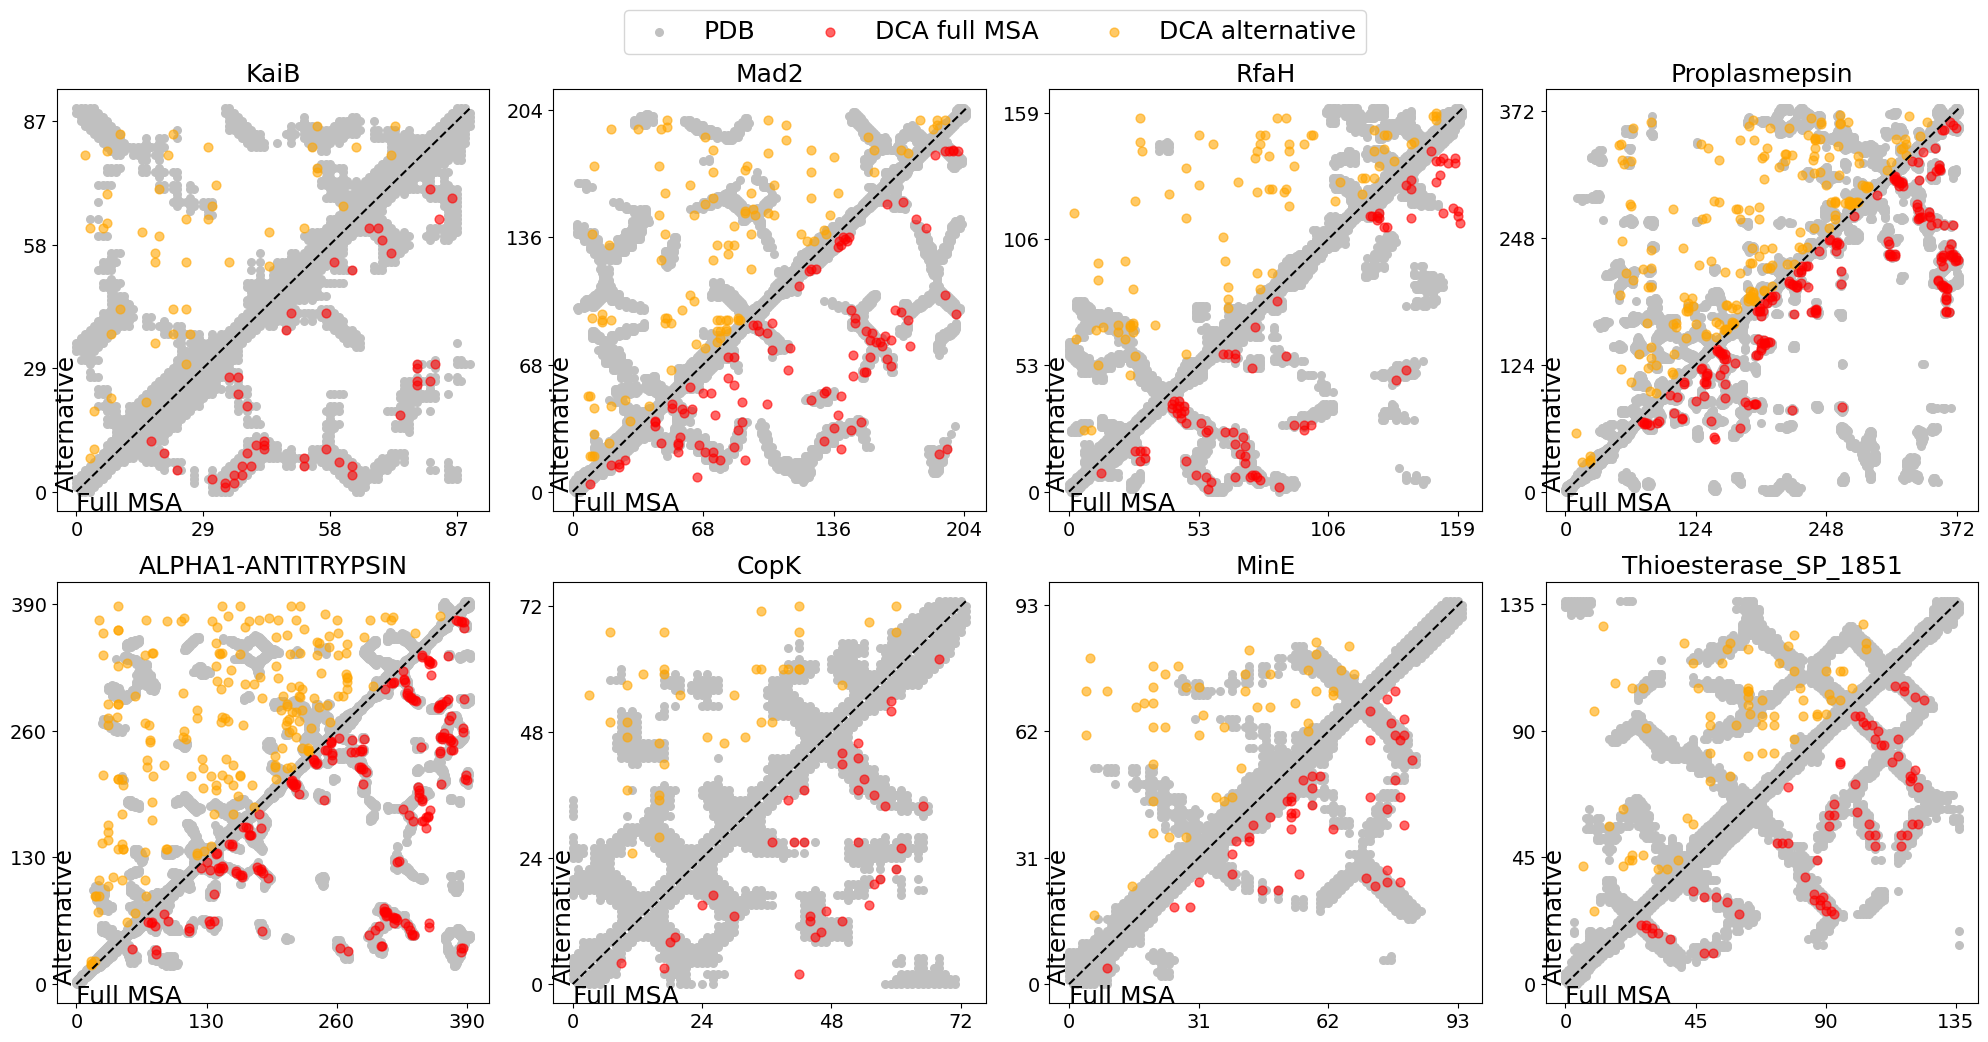

In [31]:
fig,axx = plt.subplots(2,4,figsize=(20,10))

files = ["KaiB", "Mad2", "RfaH", "Proplasmepsin", "ALPHA1-ANTITRYPSIN", "CopK",   "MinE", "Thioesterase_SP_1851"]
for p, prot in enumerate(files):
    df_sorted, dca_full, pdb_native, pdb_alternative, L = main(prot)
    if p < 4:
        ax = axx[0,p]
    else:
        ax = axx[1,p-4]
    plot_results(pdb_native, dca_full[:int(L/2)], pdb_alternative, df_sorted[:int(L/2)], ax, prot, p)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), fontsize=18, ncol=4)
plt.tight_layout()
plt.show()

In [32]:
fig.savefig('dca.jpg', bbox_inches='tight', format='jpeg', dpi=600)